In [1]:
# libraries

import pandas as pd # data frames
import numpy as np # numerical calculations
import matplotlib.pyplot as plt # to display results
from sklearn.model_selection import train_test_split # to split data into train and test
from sklearn.tree import DecisionTreeClassifier # decision tree modeling
from sklearn.ensemble import RandomForestClassifier # random forest modeling
from sklearn.metrics import classification_report,confusion_matrix # model results
from sklearn.inspection import permutation_importance # feature importance on test data

In [2]:
# get engineered and scaled data from logistic regression project and display top 5 records 

modified_data_02_df = pd.read_csv('modified_data_02_df.csv') # read from user directory

modified_data_02_df.head(5)

,PassengerId,Survived,Pclass,SibSp,Parch,Fare,Age,Military,Nobility,Peerage,Religious,Untitled,Male,EmbrkQ,EmbrkS
0,0.000000,0.0,1.0,0.125,0.0,0.014151,0.271174,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
1,0.001124,1.0,0.0,0.125,0.0,0.139136,0.472229,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.002247,1.0,1.0,0.000,0.0,0.015469,0.321438,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.003371,1.0,0.0,0.125,0.0,0.103644,0.434531,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.004494,0.0,1.0,0.000,0.0,0.015713,0.434531,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0


In [3]:
# drop features

modified_data_03_df = modified_data_02_df.drop(['Untitled'], axis=1)
modified_data_03_df.head(5)

,PassengerId,Survived,Pclass,SibSp,Parch,Fare,Age,Military,Nobility,Peerage,Religious,Male,EmbrkQ,EmbrkS
0,0.000000,0.0,1.0,0.125,0.0,0.014151,0.271174,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.001124,1.0,0.0,0.125,0.0,0.139136,0.472229,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.002247,1.0,1.0,0.000,0.0,0.015469,0.321438,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.003371,1.0,0.0,0.125,0.0,0.103644,0.434531,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.004494,0.0,1.0,0.000,0.0,0.015713,0.434531,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [4]:
# function to assess model performance

def rf_mod_assess(dataframe, target, trials, rf_est):
    
    rf_models_list = []
    
    # ith trial used as random state 
    for i in range(1,trials+1): 
        
        # split into train and test datasets
        x_train, x_test, y_train, y_test = train_test_split(dataframe.drop(target,axis=1), 
                                                            dataframe[target], test_size=0.30, 
                                                            random_state=i)
        # make predictions
        rfc = RandomForestClassifier(n_estimators=rf_est, max_features='sqrt') 
        rfc.fit(x_train,y_train)
        predictions = rfc.predict(x_test)
        
        # create classification report, reformat column wise for each trial and append to a list
        report = classification_report(y_test, predictions, output_dict=True)
        class_rep_df = pd.DataFrame(report).reset_index().pivot(columns='index')
        class_rep_df.columns = class_rep_df.columns.to_series().str.join('_') # flatten and concatenate multilevel column
        class_rep_df.insert(0, 'GrpBy', '-')
        class_rep_df = class_rep_df.groupby('GrpBy').sum().reset_index()
        class_rep_df.drop('GrpBy',axis=1,inplace=True)
        class_rep_df.drop(class_rep_df.iloc[:, 9:],axis=1,inplace=True)
        class_rep_df.rename(columns={'accuracy_f1-score':'Accuracy'}, inplace=True)
        class_rep_df.insert(9, 'Estimators', rf_est)
        class_rep_df.insert(10, 'Trials', trials)
        class_rep_df.insert(11, 'RandomState', i)
              
        # attach all data drames to a list 
        rf_models_list.append(class_rep_df)
        
    # convert list of dataframes to a single frame
    rf_models_all_df = pd.concat(rf_models_list, ignore_index=True)
    
    # change order of columns
    rf_models_all_df = rf_models_all_df[['0.0_precision', '0.0_recall', '0.0_f1-score', '0.0_support',  
                                         '1.0_precision', '1.0_recall', '1.0_f1-score', '1.0_support', 
                                         'Accuracy', 'Estimators', 'Trials', 'RandomState']] 
    # rename columns
    rf_models_all_df.rename(columns={ '0.0_precision':'0_precision', '0.0_recall':'0_recall', 
                                      '0.0_f1-score':'0_f1-score', '0.0_support':'0_support',
                                      '1.0_precision':'1_precision', '1.0_recall':'1_recall', 
                                      '1.0_f1-score':'1_f1-score', '1.0_support':'1_support',}, inplace = True)

    return rf_models_all_df.round(2)

In [5]:
# display summarized results

results_df = rf_mod_assess(modified_data_03_df, 'Survived', 25, 75)
results_avg_df = pd.DataFrame(results_df.iloc[ 0:, results_df.columns != 'RandomState'  ].mean()).transpose()
results_avg_df.round(2)

,0_precision,0_recall,0_f1-score,0_support,1_precision,1_recall,1_f1-score,1_support,Accuracy,Estimators,Trials
0,0.83,0.88,0.86,165.0,0.79,0.71,0.75,102.0,0.82,75.0,25.0


In [6]:
# display top, middle, worst results, sort by Accuracy descending  
results_df = rf_mod_assess(modified_data_03_df, 'Survived', 25, 75)
results_df.sort_values(['Accuracy'], ascending=False, inplace=True)
results_df = results_df.reset_index(drop=True)
results_df
results_df.iloc[ [0, 12, 24], results_df.columns != 'Trials']

,0_precision,0_recall,0_f1-score,0_support,1_precision,1_recall,1_f1-score,1_support,Accuracy,Estimators,RandomState
0,0.88,0.91,0.89,185.0,0.78,0.72,0.75,82.0,0.85,75,21
12,0.84,0.89,0.86,175.0,0.76,0.68,0.72,92.0,0.82,75,19
24,0.77,0.89,0.82,157.0,0.79,0.63,0.70,110.0,0.78,75,22


In [7]:
# display all results
results_df = rf_mod_assess(modified_data_03_df, 'Survived', 25, 75)
results_df

,0_precision,0_recall,0_f1-score,0_support,1_precision,1_recall,1_f1-score,1_support,Accuracy,Estimators,Trials,RandomState
0,0.85,0.90,0.88,166.0,0.82,0.74,0.78,101.0,0.84,75,25,1
1,0.85,0.90,0.87,170.0,0.80,0.71,0.75,97.0,0.83,75,25,2
2,0.78,0.92,0.84,158.0,0.85,0.61,0.71,109.0,0.80,75,25,3
3,0.80,0.87,0.83,164.0,0.75,0.65,0.70,103.0,0.78,75,25,4
4,0.85,0.89,0.87,172.0,0.78,0.72,0.75,95.0,0.83,75,25,5
5,0.84,0.90,0.87,162.0,0.82,0.73,0.77,105.0,0.83,75,25,6
6,0.83,0.89,0.86,160.0,0.82,0.73,0.77,107.0,0.83,75,25,7
7,0.81,0.84,0.83,166.0,0.73,0.68,0.70,101.0,0.78,75,25,8
8,0.82,0.87,0.85,161.0,0.78,0.72,0.75,106.0,0.81,75,25,9
9,0.84,0.90,0.87,169.0,0.80,0.69,0.74,98.0,0.82,75,25,10


In [10]:
# dispersion of accuracy 

np.std(results_df['Accuracy'])

0.02130164312911093

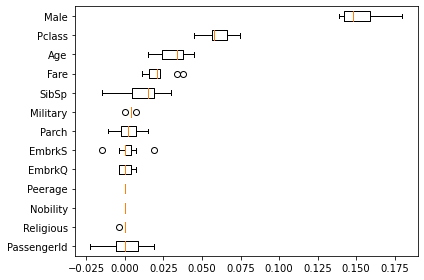

In [12]:
# feature importance

# inputs
dataframe = modified_data_03_df
target = 'Survived'
rnd_st = 19
rf_est = 75
# note: max features and scoring per sklearn documentation; otherwise parameters as per sklearn documentation

# split data into train and test
x_train, x_test, y_train, y_test = train_test_split(dataframe.drop(target,axis=1), 
                                                    dataframe[target], test_size=0.30, 
                                                    random_state=rnd_st)
# make predictions
rfc = RandomForestClassifier(n_estimators=rf_est, max_features='sqrt') 
rfc.fit(x_train,y_train)
predictions = rfc.predict(x_test)

# assess feature importance: Permutation Importances (Test Set)
result = permutation_importance(rfc, x_test, y_test, n_repeats=10,
                                random_state=rnd_st, n_jobs=2, scoring='accuracy')
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=x_test.columns[sorted_idx])
fig.tight_layout()
plt.show()